# State space models

$$
p(z) = N(\breve \mu, \breve \Sigma) 
$$
$$
p(y|z) = N(Az+b,\Omega)
$$

```
def GaussMoments(mean,covar,A,b,omega):
    a_mean = torch.matmul(A,mean)+b
    S = omega + torch.matmul(torch.matmul(A,covar),A.T)
    C = torch.matmul(covar,A.T)
    return (a_mean,S,C)

def GaussCondition(prior_mean,prior_covar,a_mean,S,C,y):
    K = torch.matmul(C,torch.inverse(S))
    t_mean = prior_mean + torch.matmul(K,(y-a_mean))
    t_covar = prior_covar - torch.matmul(torch.matmul(K,S),K.T)
    loss_fn = dist.LogNormal(loc=t_mean,scale=t_covar)
    return (t_mean,t_covar,loss_fn)
```


In [3]:
# Linear gaussian system
from sklearn.datasets import load_iris
import torch
import torch.distributions as dist
import dynamax
from jax import numpy as jnp
from jax import random as jr
from matplotlib import pyplot as plt

from dynamax.utils.plotting import  plot_uncertainty_ellipses
from dynamax.nonlinear_gaussian_ssm import ParamsNLGSSM, NonlinearGaussianSSM, UKFHyperParams
from dynamax.nonlinear_gaussian_ssm import extended_kalman_filter as ekf
from dynamax.nonlinear_gaussian_ssm import unscented_kalman_filter as ukf

key = jr.PRNGKey(0)
next_keys = jr.split(key,99)
print(next_keys.shape)

(99, 2)


## Intializations
```
iris = load_iris()
X = iris.data 
y = iris.target

D = X.shape[0]
L = X.shape[1]

mean = torch.tensor([0.0,0.0,0.0,0.0])
covar = torch.diag(torch.ones((4)))
p_z = dist.Normal(loc=mean,scale=covar)
p_y_z = dist.Normal(loc=)



```

In [48]:
state_dim = 2
obs_dim = 2
f = lambda z: z + 0.4 * jnp.array([jnp.sin(z[1]), jnp.cos(z[0])])
h = lambda z: z

params = ParamsNLGSSM(
    initial_mean = jnp.array([1.5, 0.0]),
    initial_covariance = jnp.eye(state_dim),
    # p(z_t|z_{t-1}) = N(z_t|F_t z_{t-1},Q_t)
    dynamics_function = f,
    # Q_t
    dynamics_covariance = jnp.eye(state_dim) * 0.001,
    # p(y_t|z_{t-1} = N(y_t|H_t z_t,R_t)
    emission_function = h,
    # R_t
    emission_covariance = jnp.eye(obs_dim) * 0.05
)
# distribution
nlgssm = NonlinearGaussianSSM(state_dim, obs_dim)


In [49]:
key = jr.PRNGKey(0)
# sample/ data
states, emissions = nlgssm.sample(params, key, num_timesteps=100)

In [50]:
def plot_inference(states, emissions, estimates=None, est_type="", ax=None, title="", aspect=0.8, show_states=True):
    if ax is None:
        fig, ax = plt.subplots()
    if show_states:
        ax.plot(*states.T, label="True States")
    ax.plot(*emissions.T, "ok", fillstyle="none", ms=4, label="Observations")
    if estimates is not None:
        ax.plot(*estimates.T, color="r", linewidth=1.5, label=f"{est_type} Estimate")
    #ax.set_aspect(aspect)
    ax.set_title(title)
    ax.legend(borderpad=0.5, handlelength=4, fancybox=False, edgecolor="k")
    ax.axis('equal')
    return ax

<Axes: title={'center': 'Noisy obervations from hidden trajectory'}>

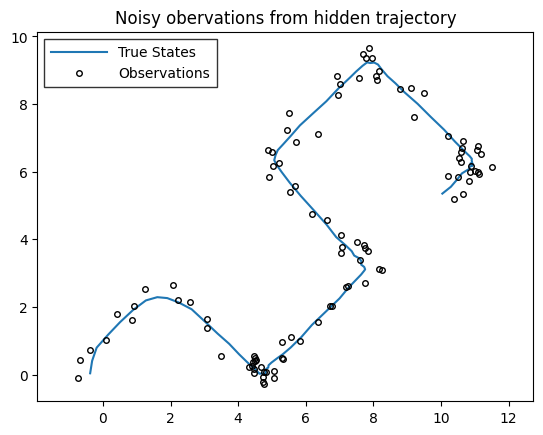

In [51]:
plot_inference(states, emissions, title="Noisy obervations from hidden trajectory")

# Analysis

100 steps for 2D, so 100x2 means and 100x2x2 covariances

In [16]:
#ekf_params = nlgssm.make_inference_args(params)
ekf_params = params
fields = ["marginal_loglik", "filtered_means", "filtered_covariances"]
ekf_post = ekf(ekf_params, emissions, output_fields=fields)
ekf_means, ekf_covs = ekf_post.filtered_means, ekf_post.filtered_covariances
print(ekf_means.shape)
print('------------')
print(ekf_covs.shape)

(100, 2)
------------
(100, 2, 2)


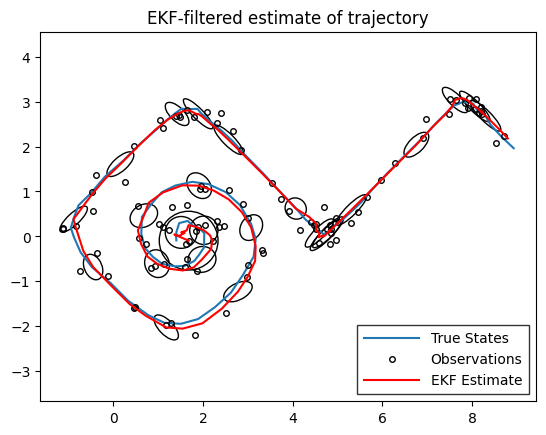

In [17]:
ax = plot_inference(states, emissions, ekf_means, "EKF", title="EKF-filtered estimate of trajectory")
# Add uncertainty ellipses to every fourth estimate
plot_uncertainty_ellipses(ekf_means[::4], ekf_covs[::4], ax)


In [24]:
hyperparams = UKFHyperParams(alpha=10, beta=10, kappa=10)
# hyperparams = UKFHyperParams()
#ukf_params = nlgssm.make_inference_args(params)
ukf_params = params
fields = ["marginal_loglik", "filtered_means", "filtered_covariances"]
ukf_post = ukf(ukf_params, emissions, hyperparams, output_fields=fields)
ukf_means, ukf_covs = ukf_post.filtered_means, ukf_post.filtered_covariances

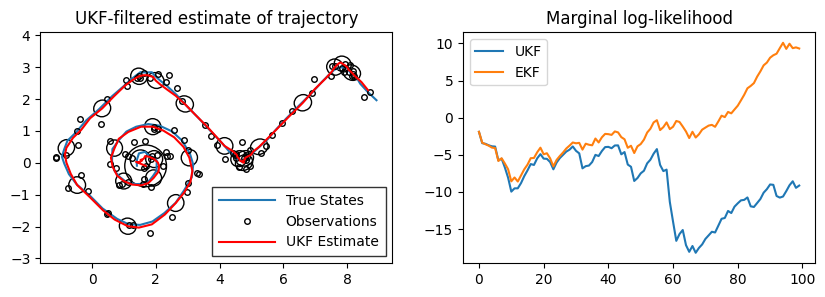

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

ax = plot_inference(states, emissions, ukf_means, "UKF", title="UKF-filtered estimate of trajectory", ax=axs[0])
# Add uncertainty ellipses to every fourth estimate
plot_uncertainty_ellipses(ukf_means[::4], ukf_covs[::4], ax)

axs[1].plot(ukf_post.marginal_loglik, label="UKF")
axs[1].plot(ekf_post.marginal_loglik, label="EKF")
axs[1].set_title("Marginal log-likelihood")
axs[1].legend()

In [26]:
hyperparams = UKFHyperParams() # use defaults
fields = ["marginal_loglik", "filtered_means", "filtered_covariances"]
ukf_post = ukf(ukf_params, emissions, hyperparams, output_fields=fields)
ukf_means, ukf_covs = ukf_post.filtered_means, ukf_post.filtered_covariances

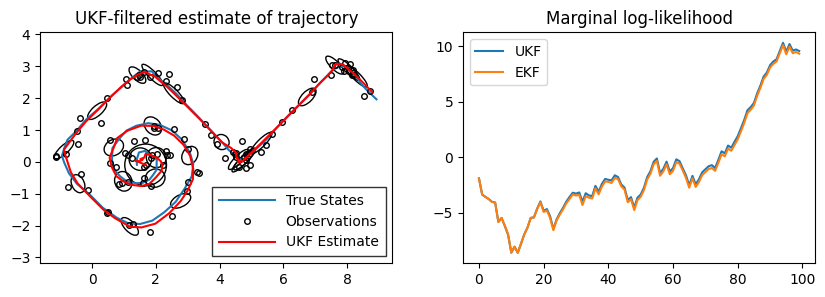

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

ax = plot_inference(states, emissions, ekf_means, "UKF", title="UKF-filtered estimate of trajectory", ax=axs[0])
# Add uncertainty ellipses to every fourth estimate
plot_uncertainty_ellipses(ukf_means[::4], ukf_covs[::4], ax)

axs[1].plot(ukf_post.marginal_loglik, label="UKF")
axs[1].plot(ekf_post.marginal_loglik, label="EKF")
axs[1].set_title("Marginal log-likelihood")
axs[1].legend()
